# END-TO-END COST BENEFIT CALCULATION

## Goal of this tutorial

The goal of this tutorial is to show a full end-to-end cost-benefit calculation. Note that this tutorial shows the work flow and some data exploration, but does not explore all possible features.

The tutorial will start with an explanation of the mathematics of an cost-benefit calculation, and then will move on to how this is implemented in CLIMADA. We will then go through a few end-to-end calculations.

If you just need to see the code in action, you can skip these first parts, which are mostly for reference.

The tutorial assumes that you're already familiar with CLIMADA's **[Hazard](climada_hazard_Hazard.ipynb)**, **[Exposures](climada_entity_Exposures.ipynb)**, **[impact functions](climada_entity_ImpactFuncSet.ipynb)**, **[Impact](climada_engine_Impact.ipynb)** and **[adaptation measure](climada_entity_MeasureSet.ipynb)** functionality. The cost-benefit calculation is often the last part of an analyses, and it brings all the previous components together. 


__[Part 1](#part1)__: What is a cost-benefit?

__[Part 2](#part2)__: CostBenefit class data structure

__[Part 3](#part3)__: Detailed CostBenefit calculation: LitPop + TropCyclone

## What is a cost-benefit?
<a id='part1'></a> 

A cost-benefit analysis in CLIMADA lets you compare the effectiveness of different hazard adaptation options.

The cost-benefit ratio describes how much loss you can prevent per dollar of expenditure (or whatever currency you're using) over a period of time. When a cost-benefit ratio is less than 1, the cost is less than the benefit and CLIMADA is predicting a worthwhile investment. Smaller ratios therefore represent better investments. When a cost-benefit is greater than 1, the cost is more than the benefit and the offset losses are less than the cost of the adaptation measure: based on the financials alone, the measure may not be worth it. Of course, users may have factors beyond just cost-benefits that influence decisions. 

CLIMADA doesn't limit cost-benefits to just financial exposures. The cost-benefit ratio could represent hospitalisations avoided per Euro spent, or additional tons of crop yield per Swiss Franc.

The cost-benefit calculation has a few complicated components, so in this section we'll build up the calculation step by step.

### Simple cost-benefits

The simplest form of a cost-benefit calculation goes like this:

$$
\text{CostBenefit} = \frac{\text{cost}}{\text{benefit}} = \frac{\text{cost}}{N * (\text{AAI without measures} - \text{AAI with measures})}
$$

where $\text{cost}$ is the cost of implementing a set of measures, the AAI is the average annual impact from your hazard event set on your exposure, and $N$ is the number of years the cost-benefit is being evaluated over.

Note that:
- Whether an adaptation measure is seen to be effective might depend on the number of years you are evaluating the cost-benefit over. For example, a €50 mn investment that prevents an average of €1 mn losses per year will only 'break even' after $N = 50$ years.
- Since an adaptation measure could in theory make an impact worse (a negative benefit) it is possible to have negative cost-benefit ratios.
- CLIMADA allows you to use other statistics than annual average impact, but to keep thing simple we'll use average annual impact throughout this tutorial.

### Time-dependence

The above equation works well when the only thing changing is an adaptation measure. But usually CLIMADA cost-benefit calculation will want to describe a climate and exposure that also change over time. In this case it's not enough to multiply the change in average annual impact by the number of years we're evaluating over, and we need to calculate a benefit for every year separately and sum them up.

We can modify the benefit part of cost-benefit to reflect this. CLIMADA doesn't assume that the user will have explicit hazard and impact objects for every year in the study period, and so interpolates between the impacts at the start and the end of the period of interest. If we're evaluating between years $T_0$, usually close to the present, and $T_1$ in the future, then we can say:

$$
\text{benefit} = \sum_{t = T_0}^{T_1} \alpha(t) \bigg{(} \text{AAI with measures}_{T_1} - \text{AAI with measures}_{T_0} \bigg{)} - N * \text{AAI without measure}_{T_0}
$$

Where $\alpha(t)$ is a function of the year $t$ describing the interpolation of hazard and exposure values between $T_0$ and $T_1$. The function returns values in the range $[0, 1]$, usually with $\alpha(T_0) = 0$ and $\alpha(T_0) = 1$.

Note that:
- This calculation now requires three separate impact calculations: present-day impacts without measures implemented, present-day impacts with measures implemented, and future impacts with measures implemented.
- Setting $\alpha(t) = 1$ for all values of $t$ simplifies this to the first cost-benefit equation above.

CLIMADA lets you set $\alpha(t)$ to 1 for all years $t$, or as
$$
\alpha_k(t) = \frac{(t - T_0)^k}{(T_1 - T_0)^k}  \;\; \text{for} \; t \in [T_0, T_1]
$$

where $k$ is user-provided, called `imp_time_depen`. This expression is a polynomial curve between $T_0$ and $T_1$ normalised so that $\alpha_k(T_0) = 0$ and $\alpha_k(T_1) = 1$. The choice of $k$ determines how quickly the transition occurs between the present and future. When $k = 1$ the function is a straight line. When $k > 1$ change begins slowly and speeds up over time. When $k < 1$ change is begins quickly and slows over time.

If this math is tough, the key takeaways are
- Cost benefit calculations take a long view, summing the benefits of adaptation measures over many years in a changing world
- CLIMADA describes how the change from the present to the future scenarios happens with the `imp_time_depen` parameter. With values < 1 the change starts quickly and slows down. When it is equal to 1 change is steady. When it's > 1 change starts slowly and speeds up.

### Discount rates

The final addition to our cost-benefit calculation is the *discount rate*.

The discount rate tries to formalise an idea from economics that says that a gain in the future is worth less to us than the same gain right now. For example, paying €1 mn to offset €2 mn of economic losses next year is 'worth more' than paying €1 mn to offset €2 mn of economic losses in 2080.

In practice it provides a way to future monetary values to an estimated worth today, called their *net present value*. Note that this is *not* an adjustment for inflation.

The choice of discount rate is a contentious topic in adaptation finance, since it can strongly affect a cost-benefit calculation. The most widley used discount rate in climate change economics is 1.4% as proposed by the Stern Review (2006). Neoliberal economists around Nordhaus (2007) claim that rates should be higher, around 4.3%, reflecting continued economic growth and a society that will be better at adapting in the future compared to now. Environmental economists argue that future costs shouldn't be discounted at all.

To illustrate, with a 1.4\% annual discount rate, a gain of €100 next year is equivalent to €98.60 this year, and a gain of €100 in 15 years is equivalent to $ € (100 * 0.986^{15})$ = € 80.94 this year. With a rate of 4.3\% this drops to €51.72.

We can add this into the cost-benefit calculation by defining $d(t)$, the discount rate for each year $t$. A constant rate of 1.4\% would then set $d(t) = 0.014$ for all values of $t$.

Then the adjustment $D(t)$ from year $t$ to the net present value in year $T_0$ is given by

$$
D(t) = \prod_{y = T_0}^{t} (1 - d(y))
$$

With a constant 1.4\% discount rate, we have $D(t) = 0.986^{t - T_0}$. With a discount rate of zero we have $D(t) = 1$.

Adding this to our equation for total benefits we get:

$$
\text{benefit} = \sum_{t = T_0}^{T_1} \alpha(t) D(t) \bigg{(} \text{AAI with measures}_{T_1} - \text{AAI with measures}_{T_0} \bigg{)} - N * \text{AAI without measure}_{T_0}
$$

Note:
- Setting the rates to zero ($d(t) = 0$) means $D(t) = 1$ and the term drops out of the equation.
- Be careful with your choice of discount rate when your exposure is non-economic. It can be hard to justify applying rates to e.g. ecosystems or human lives.


## CostBenefit class data structure
<a id='part2'></a> 

The CostBenefit class does not require any attributes to be defined by the user. All attributes are set from parameters when the method `CostBenefit.calc()` is called.

After calling the `calc` method the `CostBenefit` object has the following attributes:

| Attributes created in `CostBenefit.calc` | Data Type | Description|
| :- | :- | :- |
| present_year | int | The current year |
| future_year | int | The future scenario year |
| tot_climate_risk | float | The total climate risk in the present scenario, evaluated according to the provided risk function (annual average impact by default) |
| unit | string | Units to measure impact |
| benefit | dict(float) | The benefit of each measure, keyed by measure name |
| cost_ben_ratio | dict(float) | The cost benefit of each measure, keyed by measure name |
| imp_meas_future | dict(dict) | Dictionaries describing the impacts of each measure in the future scenario. Keyed by measure name (with 'no measure' for no measures). The entries in each dictionary are described below. |
| imp_meas_present | dict(dict) | Dictionaries describing the impacts of each measure in the present-day scenario. Keyed by measure name (with 'no measure' for no measures). The entries in each dictionary are described below. |


Each dictionary stored in the attributes `imp_meas_future` and `imp_meas_present` has entries:

| Key | Data Type | Description |
| :- | :- | :- |
| cost | tuple (cost measure, cost factor insurance) | The cost of implementing the measure, and the cost factor if risk transfers are being calculated |
| impact | Impact | Impact object calculated with the present (`imp_meas_present`) or future (`imp_meas_future`) hazard, exposure and impact functions |
| risk | float | A value of annual risk used in the cost-benefit calculation. A summary statistic calculated from the Impact object. Most commonly the average annual impact, but can be changed with the `CostBenefit.calc`'s `risk_func`parameter. |
| risk_transf | float | Annual expected risk transfer (if calculated) |
| efc | ImpactFreqCurve | The impact exceedance freq for this measure calculated from the Impact object (if calculated) |


The dictionary will also include a 'no measure' entry with the same structure, giving the impact analysis when no measures are implemented.

### The `calc` calculation

Let's look at the parameters needed for the calculation:
```
CostBenefit.calc(hazard, entity, haz_future=None, ent_future=None,
                 future_year=None, risk_func=risk_aai_agg, imp_time_depen=None, save_imp=False)
```

These are:
- `hazard` (Hazard object): the present-day or baseline hazard event set
- `entity` (Entity object): the present-day or baseline Entity object. `Entity` is the container class containing 
    - `exposure` (Exposures object): the present-day or baseline exposure
    - `disc_rates` (DiscRates object): the discount rates to be applied in the cost-benefit calculation. Only discount rates from `entity` and not `ent_future` are used.
    - `impact_funcs` (ImpactFuncSet object): the impact functions required to calculate impacts from the present-day hazards and exposures
    - `measures` (MeasureSet object): the set of measures to implement in the analysis. This will almost always be the same as the measures in the `ent_future` Entity (if set).
- `haz_future` (Hazard object, optional): the future hazard event set, if different from present.
- `ent_future` (Entity object, optional): the future Entity, if different from present. Note that the same adaptation measures must be present in both `entity` and `ent_future`.
- `future_year` (int): the year of the future scenario. This is only used if the Entity's `exposures.ref_year` isn't set, or no future entity is provided. 
- `risk_func` (function): this is the risk function used to describe the annual impacts used to describe benefits. The default is `risk_aai_agg`, the average annual impact on the Exposures (defined in the CostBenefit module). This function can be replaces with any function that takes an Impact object as input and returns a number. The CostBenefit module provides two others functions `risk_rp_100` and `risk_rp_250`, the 100-year and 250-year return period impacts respectively.
- `imp_time_depen` (float): This describes how hazard and exposure evolve over time in the calculation. In the descriptions above this is the parameter $k$ defining $\alpha_k(t)$. When > 1 change is superlinear and occurs nearer the start of the analysis. When < 1 change is sublinear and occurs nearer the end.
- `save_imp` (boolean): whether to save the hazard- and location-specific impact data. This is used in a lot of follow-on calculations, but is very large if you don't need it.


## Detailed CostBenefit calculation: LitPop + TropCyclone
<a id='part3'></a> 

We present a detailed example for the hazard __[Tropical Cyclones](climada_hazard_TropCyclone.ipynb)__ and the exposures from __[LitPop](climada_entity_LitPop.ipynb)__ .

To speed things up we'll use the CLIMADA Data API to download the data as needed. The data download roughly follows the __[Data API tutorial](climada_util_api_client.ipynb)__ for Haiti. If this is a problem you can build tropical cyclone event sets, and LitPop exposures following the relevant tutorials.

### Download hazard

We will get data for present day tropical cyclone hazard in Haiti, and for 2080 hazard under the RCP 8.5 warming scenario. Note that the Data API provides us with a full event set of wind footprints rather than a TCTracks track dataset, meaning we don't have to generate the wind fields ourselves.

In [1]:
from climada.util.api_client import Client

client = Client()
future_year = 2080
haz_present = client.get_hazard('tropical_cyclone', 
                                properties={'country_name': 'Haiti', 
                                            'climate_scenario': 'historical',
                                            'nb_synth_tracks':'10'})
haz_future = client.get_hazard('tropical_cyclone', 
                                properties={'country_name': 'Haiti', 
                                            'climate_scenario': 'rcp85',
                                            'ref_year': str(future_year),
                                            'nb_synth_tracks':'10'})


2022-03-03 05:35:22,192 - climada.hazard.base - INFO - Reading /Users/chrisfairless/climada/data/hazard/tropical_cyclone/tropical_cyclone_10synth_tracks_150arcsec_HTI_1980_2020/v1/tropical_cyclone_10synth_tracks_150arcsec_HTI_1980_2020.hdf5
2022-03-03 05:35:28,402 - climada.hazard.base - INFO - Reading /Users/chrisfairless/climada/data/hazard/tropical_cyclone/tropical_cyclone_10synth_tracks_150arcsec_rcp85_HTI_2080/v1/tropical_cyclone_10synth_tracks_150arcsec_rcp85_HTI_2080.hdf5


We can plot the hazards and show how they are forecast to intensify. For example, showing the strength of a 50-year return period wind in present and future climates:

2022-03-03 05:35:28,479 - climada.hazard.base - INFO - Computing exceedance intenstiy map for return periods: [50]
2022-03-03 05:35:36,986 - climada.hazard.base - INFO - Computing exceedance intenstiy map for return periods: [50]


(<GeoAxesSubplot:title={'center':'Return period: 50 years'}>,
 array([[41.84896948, 41.98439726, 41.62016887, ..., 49.52344953,
         51.35294266, 51.51945831]]))

/Users/chrisfairless/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/chrisfairless/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/chrisfairless/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(

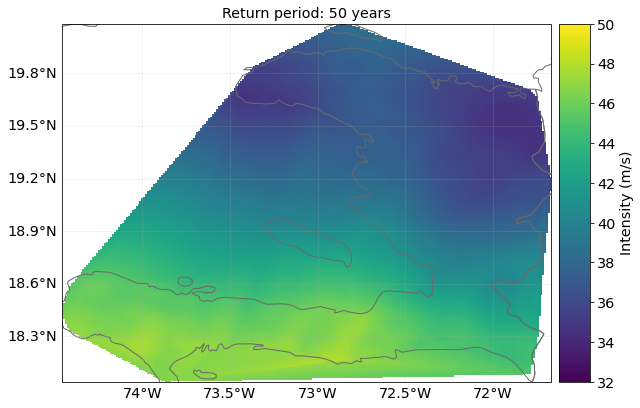

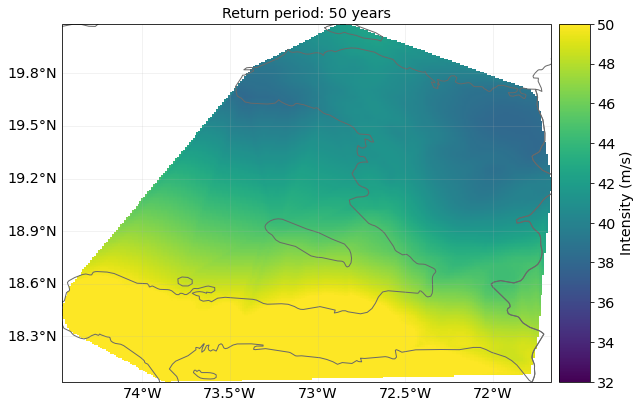

In [2]:
# Plot the hazards, showing 50-year return period hazard
haz_present.plot_rp_intensity(return_periods=(50,), smooth=False, vmin=32, vmax=50)
haz_future.plot_rp_intensity(return_periods=(50,), smooth=False, vmin=32, vmax=50)

### Download LitPop economic exposure data

The Data API provides us with economic exposure data:

In [3]:
exp_present = client.get_litpop_default(country='Haiti')

2022-03-03 05:35:52,700 - climada.entity.exposures.base - INFO - Reading /Users/chrisfairless/climada/data/exposures/litpop/LitPop_150arcsec_HTI/v1/LitPop_150arcsec_HTI.hdf5


For 2080's economic exposure we will use a crude approximation, assuming the country will experience 2% economic growth annually:

In [4]:
import copy

exp_future = copy.deepcopy(exp_present)
exp_future.ref_year = future_year
n_years = exp_future.ref_year - exp_present.ref_year + 1
growth_rate = 1.02
growth = growth_rate ** n_years
exp_future.gdf['value'] = exp_future.gdf['value'] * growth

We can plot the current and future exposures. The default scale is logarithmic and we see how the values of exposures grow, though not by a full order of magnitude.

2022-03-03 05:35:52,895 - climada.util.coordinates - INFO - Raster from resolution 0.04166666666666785 to 0.04166666666666785.


/Users/chrisfairless/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
/Users/chrisfairless/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/chrisfairless/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-pa

2022-03-03 05:35:59,536 - climada.util.coordinates - INFO - Raster from resolution 0.04166666666666785 to 0.04166666666666785.


/Users/chrisfairless/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
/Users/chrisfairless/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/chrisfairless/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-pa

<GeoAxesSubplot:>

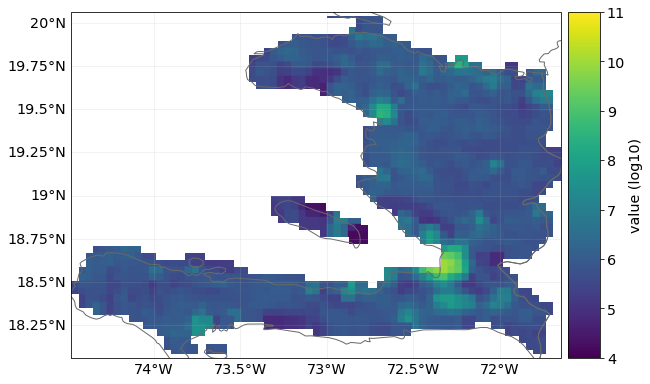

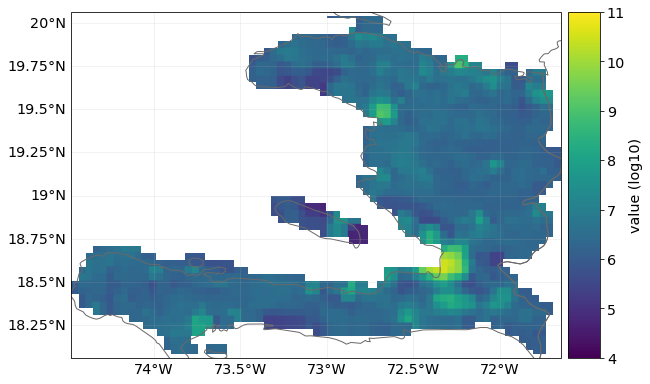

In [5]:
exp_present.plot_raster(fill=False, vmin=4, vmax=11)
exp_future.plot_raster(fill=False, vmin=4, vmax=11)

We then need to map the exposure points to the hazard centroids. (Note: we could have done this earlier before we copied the exposure, but not all analyses will have present and future exposures and hazards on the same sets of points.)

In [6]:
# This would be done automatically in Impact calculations
# but it's better to do it explicitly before the calculation
exp_present.assign_centroids(haz_present, distance='approx')
exp_future.assign_centroids(haz_future, distance='approx')

2022-03-03 05:36:15,405 - climada.entity.exposures.base - INFO - Matching 1329 exposures with 1329 centroids.
2022-03-03 05:36:15,421 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2022-03-03 05:36:16,026 - climada.entity.exposures.base - INFO - Matching 1329 exposures with 1329 centroids.
2022-03-03 05:36:16,042 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100


### Define impact function 

In this analysis we'll use the popular sigmoid curve impact function from Emanuel (2011).

2022-03-03 05:36:16,069 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


<AxesSubplot:title={'center':'TC 1: Emanuel 2011'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>

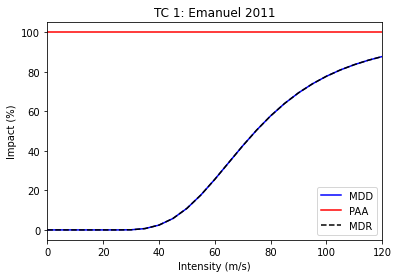

In [7]:
from climada.entity import ImpactFuncSet, ImpfTropCyclone

impf_tc = ImpfTropCyclone.from_emanuel_usa()

# add the impact function to an Impact function set
impf_set = ImpactFuncSet()
impf_set.append(impf_tc)
impf_set.check()
impf_tc.plot()

In [8]:
# Rename the impact function column in the exposures and assign hazard IDs

# This is more out of politeness, since if there's only one impact function
# and one `impf_` column, CLIMADA can figure it out
exp_present.gdf.rename(columns={"impf_": "impf_TC"}, inplace=True)
exp_present.gdf['impf_TC'] = 1
exp_future.gdf.rename(columns={"impf_": "impf_TC"}, inplace=True)
exp_future.gdf['impf_TC'] = 1

### Define adaptation measures

For adaptation measures we'll follow some of the examples from the __[Adaptation MeasureSet tutorial](climada_entity_MeasureSet.ipynb)__. See the tutorial to understand how measures work in more depth.

These numbers are completely made up. We implement one measure that reduces the (effective) wind speed by 5 m/s and one that completely protects 10% of exposed assets.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from climada.entity.measures import Measure, MeasureSet

meas_1 = Measure()
meas_1.haz_type = 'TC'
meas_1.name = 'Measure A'
meas_1.color_rgb = np.array([0.8, 0.1, 0.1])
meas_1.cost = 5000000000
meas_1.hazard_inten_imp = (1, -5)     # Decrease wind speeds by 5 m/s   
meas_1.risk_transf_cover = 0

meas_2 = Measure()
meas_2.haz_type = 'TC'
meas_2.name = 'Measure B'
meas_2.color_rgb = np.array([0.1, 0.1, 0.8])
meas_2.cost = 220000000
meas_2.paa_impact = (1, -0.10)   # 10% fewer assets affected

# gather all measures
meas_set = MeasureSet()
meas_set.append(meas_1)
meas_set.append(meas_2)
meas_set.check()

### Define discount rates

We'll define two discount rate objects so that we can compare their effect on a cost-benefit. First, a zero discount rate, where preventing loss in 2080 is valued the same a preventing it this year. Second, the often-used 1.4% per year.

In [10]:
from climada.entity import DiscRates

year_range = np.arange(exp_present.ref_year, exp_future.ref_year + 1)
annual_discount_zero = np.zeros(n_years)
annual_discount_stern = np.ones(n_years) * 0.014

discount_zero = DiscRates(year_range, annual_discount_zero)
discount_stern = DiscRates(year_range, annual_discount_stern)

### Create Entity objects

Now we have everything we need to create Entities. Remember, Entity is a container class for grouping __[Exposures](climada_entity_Exposures.ipynb)__, __[Impact Functions](climada_entity_ImpactFuncSet.ipynb)__, __[Discount Rates](climada_entity_DiscRates.ipynb)__ and __[Measures](climada_entity_MeasureSet.ipynb)__.

In this first example we'll set discount rates to zero.

In [11]:
from climada.entity import Entity

entity_present = Entity(exposures=exp_present, disc_rates=discount_zero,
                        impact_func_set=impf_set, measure_set=meas_set)
entity_future = Entity(exposures=exp_future, disc_rates=discount_zero,
                       impact_func_set=impf_set, measure_set=meas_set)

### Cost-benefit #1: adaptation measures, no climate change or economic growth

We are now ready to perform our first cost-benefit analysis. We'll start with the simplest and build up complexity.

The first analysis only looks at solely at the effects of introducing adaptation measures. It assumes no climate change and no economic growth. It evaluates the benefit over the period 2018 (present) to 2080 (future) and sets the discount rate to zero.

In [12]:
from climada.engine import CostBenefit
from climada.engine.cost_benefit import risk_aai_agg

costben_measures_only = CostBenefit()
costben_measures_only.calc(haz_present, entity_present, haz_future=None, ent_future=None,
                           future_year=future_year, risk_func=risk_aai_agg, imp_time_depen=None, save_imp=True)

2022-03-03 05:36:16,236 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-03-03 05:36:16,238 - climada.engine.impact - INFO - Calculating damage for 1329 assets (>0) and 42779 events.
2022-03-03 05:36:16,258 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-03-03 05:36:16,259 - climada.engine.impact - INFO - Calculating damage for 1329 assets (>0) and 42779 events.
2022-03-03 05:36:16,295 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-03-03 05:36:16,296 - climada.engine.impact - INFO - Calculating damage for 1329 assets (>0) and 42779 events.
2022-03-03 05:36:16,332 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2018 to 2080.

Measure      Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
---------  ---------------  ------------------  --------------
Measure A             5                4.74132        0.948265
Measure B             0.22             1.1

Let's take a moment to look through these results.

The first table gives us a breakdown of cost-benefits by measure. We can see that, the Benefit/Cost for measure A is very just under 1, meaning that the damage prevented is slightly less than the cost of preventing it (according to the model). In comparison, the benefit of Measure B is 5 times the cost. (Note that Benefit/Cost is the inverse of Cost/Benefit: larger numbers are better).

Let's explain the three values in the second table:
- **Total climate risk:** The impact expected over the entire study period. With no changes in future hazard or exposure and no discount rates we can check that it is 63 times the next term.
- **Average annual risk:** The average annual risk without any measures implemented in the future scenario (which here is the same as the present day scenario)
- **Residual risk:** The remaining risk that hasn't been offset by the adaptation measures. Here it is the total climate risk minus the total of the 'Benefit' column of the table above it.

#### Combining measures

We can also combine the measures to give the cost-benefit of implementing everything:

In [13]:
combined_costben = costben_measures_only.combine_measures(['Measure A', 'Measure B'],
                                                          'Combined measures',
                                                          new_color=np.array([0.1, 0.8, 0.8]),
                                                          disc_rates=discount_zero)


Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Combined measures             5.22             5.84344         1.11943

--------------------  ---------  --------
Total climate risk:   11.0613    (USD bn)
Average annual risk:   0.175576  (USD bn)
Residual risk:         5.21787   (USD bn)
--------------------  ---------  --------
Net Present Values


Note: the method of combining measures is naive. The offset impacts are summed over the event set while not letting the impact of any single event drop below zero (it therefore doesn't work in analyses where impacts can go below zero).

#### Plotting benefits by return period 

Finally, we can see how effective the adaptation measures are at different return periods. The `plot_event_view` plot shows the different in losses at different return periods in the future scenario (here the same as the present scenario) with the losses offset by the adaptation measures shaded.

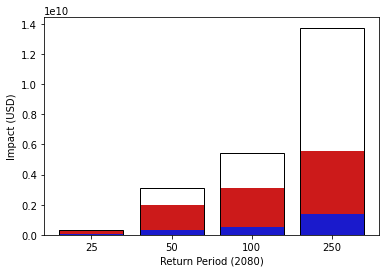

In [14]:
ax = costben_measures_only.plot_event_view((25, 50, 100, 250))

We see that the Measure A, which reduces wind speeds by 5 m/s, is able to completely stop impacts at the 25 year return period, and that at 250 years – the strongest events – the measures have greatly reduced effectiveness.

### Cost-benefit #2: adaptation measures with climate change and economic growth

Our next analysis will introduce a change in future scenarios. We'll add `hazard_future` and `entity_future` into the mixture. We'll set `imp_time_depen` set to 1, meaning we interpolate linearly between the present and future hazard and exposures in our summation over years. We'll still keep the discount rate at zero.

In [15]:
costben = CostBenefit()
costben.calc(haz_present, entity_present, haz_future=haz_future, ent_future=entity_future,
             future_year=future_year, risk_func=risk_aai_agg, imp_time_depen=1, save_imp=True)

2022-03-03 05:36:16,478 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-03-03 05:36:16,480 - climada.engine.impact - INFO - Calculating damage for 1329 assets (>0) and 42779 events.
2022-03-03 05:36:16,498 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-03-03 05:36:16,500 - climada.engine.impact - INFO - Calculating damage for 1329 assets (>0) and 42779 events.
2022-03-03 05:36:16,534 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-03-03 05:36:16,535 - climada.engine.impact - INFO - Calculating damage for 1329 assets (>0) and 42779 events.
2022-03-03 05:36:16,572 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-03-03 05:36:16,574 - climada.engine.impact - INFO - Calculating damage for 1329 assets (>0) and 16808 events.
2022-03-03 05:36:16,592 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-03-03 05:36:16,

What has changed by adding climate change and population growth?

- With growing exposure and more extreme events we see about a 3-fold increase in total climate risk. Remember this is the average annual impacts summed over every year between the present and the future. The average annual risk has grown even more, by over a factor of 5. This represents the unadapted annual impacts in the future scenario.
- Greater impacts means that our adaptation measures offset more in absolute terms. The same adaptation measures create larger benefits (and therefore cost-benefits), which have increased by about a factor of three. Measure A is now clearly worth implementing in this cost-benefit analysis, whereas it wasn't before.
- We also see that the residual risk, i.e. the impacts over the analysis period that are not offset by the adaptation measures, is much larger.

**Exercise**: try changing the value of the `imp_time_depen` parameter in the calculation above. Values < 1 front-load the changes over time, and values > 1 back-load the changes. How does it affect the values in the printout above? What changes? What doesn't?

#### Waterfall plots 

Now that there are more additional components in the analysis, we can use more of the CostBenefit class's visualisation methods. The waterfall plot is the clearest way to break down the components of risk:

2022-03-03 05:36:16,647 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-03-03 05:36:16,649 - climada.engine.impact - INFO - Calculating damage for 1329 assets (>0) and 42779 events.
2022-03-03 05:36:16,665 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-03-03 05:36:16,667 - climada.engine.impact - INFO - Calculating damage for 1329 assets (>0) and 16808 events.
2022-03-03 05:36:16,695 - climada.engine.cost_benefit - INFO - Risk at 2018: 1.756e+08
2022-03-03 05:36:16,696 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-03-03 05:36:16,699 - climada.engine.impact - INFO - Calculating damage for 1329 assets (>0) and 42779 events.
2022-03-03 05:36:16,714 - climada.engine.cost_benefit - INFO - Risk with development at 2080: 6.113e+08
2022-03-03 05:36:16,715 - climada.engine.cost_benefit - INFO - Risk with development and climate change at 2080: 9.844e+08


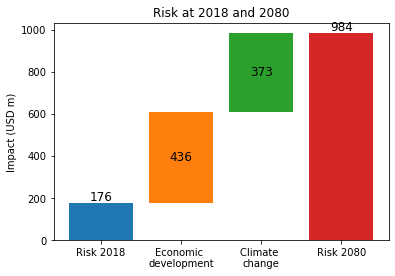

In [16]:
# define this as a function because we'll use it again later
def waterfall():
  return costben.plot_waterfall(haz_present, entity_present, haz_future, entity_future,
                                risk_func=risk_aai_agg)

ax = waterfall()

The waterfall plot breaks down the average annual risk faced in 2080 (this is \\$0.984 bn, as printed out during the cost-benefit calculation).

We see that the baseline 2018 risk in blue. The 'Economic development' bar in orange shows the change in annual impacts resulting from growth in exposure, and the 'Climate change' bar in green shows the additional change from changes in the hazard.

In this analysis, then, we see that changes in annual losses are likely to be driven by both economic development and climate change, in roughly equal amounts.

The `plot_arrow_averted` graph builds on this, adding an indication of the risk averted to the waterfall plot. It's slightly awkward to use, which is why we wrote a function to create the waterfall plot earlier:

2022-03-03 05:36:16,803 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-03-03 05:36:16,804 - climada.engine.impact - INFO - Calculating damage for 1329 assets (>0) and 42779 events.
2022-03-03 05:36:16,820 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-03-03 05:36:16,821 - climada.engine.impact - INFO - Calculating damage for 1329 assets (>0) and 16808 events.
2022-03-03 05:36:16,849 - climada.engine.cost_benefit - INFO - Risk at 2018: 1.756e+08
2022-03-03 05:36:16,850 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-03-03 05:36:16,851 - climada.engine.impact - INFO - Calculating damage for 1329 assets (>0) and 42779 events.
2022-03-03 05:36:16,866 - climada.engine.cost_benefit - INFO - Risk with development at 2080: 6.113e+08
2022-03-03 05:36:16,867 - climada.engine.cost_benefit - INFO - Risk with development and climate change at 2080: 9.844e+08


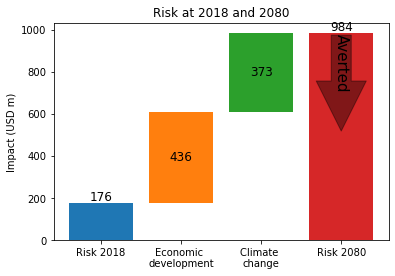

In [17]:
costben.plot_arrow_averted(axis = waterfall(), in_meas_names=['Measure A', 'Measure B'], accumulate=True, combine=False,
                           risk_func=risk_aai_agg, disc_rates=None, imp_time_depen=1)

**Exercise**: In addition, the `plot_waterfall_accumulated` method is available to produce a waterfall plot from a different perspective. Instead of showing a breakdown of the impacts from the year of our future scenario, it accumulates the components of risk over the whole analysis period. That is, it sums the components over every year between 2018 (when the entire risk is the baseline risk) to 2080 (when the breakdown is the same as the plot above). The final plot has the same four components, but gives them different weightings. Look up the function in the `climada.engine.cost_benefit` module and try it out. Then try changing the value of the `imp_time_depen` parameter, and see how front-loading or back-loading the year-on-year changes gives different totals and different breakdowns of risk.

### Cost-benefit #3: Adding discount rates

Next we will introduce discount rates to the calculations. Recall that discount rates are factors used to convert future impacts into present-day impacts, based on the idea that an impact in the future is less significant than the same impact today.

We will work with the annual 1.4% discount that we defined earlier in the `discount_stern` object. Let's define two new Entity objects with these discount rates:

In [18]:
entity_present_disc = Entity(exposures=exp_present, disc_rates=discount_stern,
                             impact_func_set=impf_set, measure_set=meas_set)
entity_future_disc = Entity(exposures=exp_future, disc_rates=discount_stern,
                            impact_func_set=impf_set, measure_set=meas_set)

And then re-calculate the cost-benefits:

In [19]:
costben_disc = CostBenefit()
costben_disc.calc(haz_present, entity_present_disc, haz_future=haz_future, ent_future=entity_future_disc,
                  future_year=future_year, risk_func=risk_aai_agg, imp_time_depen=1, save_imp=True)
print(costben_disc.imp_meas_future['no measure']['impact'].imp_mat.shape)

2022-03-03 05:36:16,969 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-03-03 05:36:16,971 - climada.engine.impact - INFO - Calculating damage for 1329 assets (>0) and 42779 events.
2022-03-03 05:36:16,988 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-03-03 05:36:16,989 - climada.engine.impact - INFO - Calculating damage for 1329 assets (>0) and 42779 events.
2022-03-03 05:36:17,024 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-03-03 05:36:17,026 - climada.engine.impact - INFO - Calculating damage for 1329 assets (>0) and 42779 events.
2022-03-03 05:36:17,062 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-03-03 05:36:17,064 - climada.engine.impact - INFO - Calculating damage for 1329 assets (>0) and 16808 events.
2022-03-03 05:36:17,079 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2022-03-03 05:36:17,

How has this changed the numbers?

- The benefits have shrunk, since the values of the impacts prevented in the future have decreased. This means the benefit/cost ratios have decreased too. Nevertheless Measure A still has benefits that outweigh the costs.
- The total climate risk has decreased. The risk is the sum of impacts (with no adaptation measures) over the whole analysis period. Since future impacts are all smaller than they were without discount rates, the sum has decreased.
- The average annual risk, the unadapted annual risk in the future scenario, is the same (although it would be less if it was converted to a net present value).
- The residual risk has also shrunk. It has been discounted in the same way as the offset impacts.

Take together we see a slightly more optimistic outlook for climate change, as the future risks are smaller, but less attractive investments in offsetting these risks, since the benefit/cost ratio has shrunk.

#### Additional data exploration

With scenarios like this, the `CostBenefit.plot_cost_benefit` method shows a 2-dimensional representation of the cost-benefits.

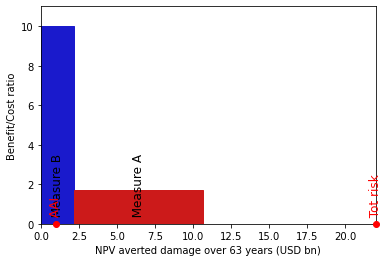

In [20]:
ax = costben_disc.plot_cost_benefit()

The x-axis here is damage averted over the 2018-2080 analysis period. The y-axis is the Benefit/Cost ratio (so higher is better). This means that the area of each shape represents the total benefit of the measure. Furthermore, any measure which goes above 1 on the y-axis gives a larger benefit than the cost of its implementation.

The average annual impact and the total climate risk are marked on the x-axis. The width between the last measure bar and the the total climate risk is the residual risk.

**Exercise**: How sensitive are cost benefit analyses to different parameters? Let's say an adaptation measure is a 'good investment' if the benefit is greater than the cost over the analysis period, and it's a 'bad investment' if the benefit is less than the cost.
- Using the hazards and exposures from this tutorial, can you design an impact measure that is a good investment when no discount rates are applied, and a bad investment when a 1.4% (or higher) discount rate is applied?  
- Create hazard and exposure objects for the same growth and climate change scenarios as this tutorial, but for the year 2040. Can you design an impact measure that is a good investment when evaluated out to 2080, but a bad investment when evaluated to 2040?
- Using the hazards and exposures from this tutorial, can you design an impact measure that is a good investment when `imp_time_depen` = 1/4 (change happens closer to 2018) and a bad investment when `imp_time_depen` = 4 (change happens closer to 2080).

Finally we can use some of the functionality of the objects stored within the CostBenefit object. Remember that many impact calculations have been performed to get here, and if `imp_mat` was set to True, the data has been stored (or ... it will be. I found a bug that stops it being saved while writing the tutorial.)

So this means that you can, for example, plot maps of return period hazard with different adaptation measures applied (or with all applied, using `combine_measures`).

Another thing to explore is exceedance curves, which are stored. Here are the curves for the present, future unadapted and future adapted scenarios:


Measure              Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-----------------  ---------------  ------------------  --------------
Combined measures             5.22             10.6616         2.04245

--------------------  ---------  --------
Total climate risk:   22.0086    (USD bn)
Average annual risk:   0.984382  (USD bn)
Residual risk:        11.347     (USD bn)
--------------------  ---------  --------
Net Present Values


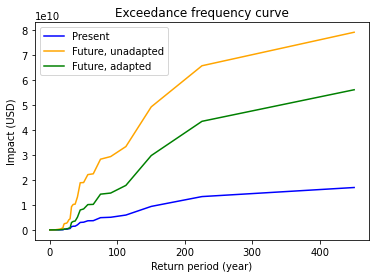

In [21]:
combined_costben_disc = costben_disc.combine_measures(['Measure A', 'Measure B'],
                                                      'Combined measures',
                                                      new_color=np.array([0.1, 0.8, 0.8]),
                                                      disc_rates=discount_stern)
efc_present = costben_disc.imp_meas_present['no measure']['efc']
efc_future = costben_disc.imp_meas_future['no measure']['efc']
efc_combined_measures = combined_costben_disc.imp_meas_future['Combined measures']['efc']

ax = plt.subplot(1, 1, 1)
efc_present.plot(axis=ax, color='blue', label='Present')
efc_future.plot(axis=ax, color='orange', label='Future, unadapted')
efc_combined_measures.plot(axis=ax, color='green', label='Future, adapted')
leg = ax.legend()

## Conclusion

Cost-benefits calculations can be powerful policy tools, but they are as much an art as a science. Describing your adaptation measures well, choosing the period to evaluate them over, describing the changing climate and picking a discount rate will all affect your results and whether a particular measure is worth implementing.

Take the time to explain these choices to yourself and anyone else who wants to understand your calculations. It is also good practice to run sensitivity tests on your results: how much do your conclusions change when you use other plausible setups for the calculation?